In [24]:
import pm4py

event_log = pm4py.read_xes("data/Road_Traffic_Fine_Management_Process.xes")


parsing log, completed traces :: 100%|██████████| 150370/150370 [00:11<00:00, 13279.41it/s]


# Session 1

## Task 1.1

- *a)* 2000-01-01 00:00:00+00:00 to 2013-06-18 00:00:00+00:00
- *b)* 113
- *c)*
    - *min:* 0.0
    - *median:* 35.0
    - *max:* 4351.0
    - *recommendation:* The median is very distant from the maximum, in fact only 9 entries have an initial fine amount of over 900. 
- *d)* 4,160 / 4124

# Session 2

## Task 1

In [26]:
import pandas as pd


# First, sort by case identifier and by time or event order if available
event_log = event_log.sort_values(by=['case:concept:name', 'time:timestamp'])

event_log['paymentAmount'] = event_log['paymentAmount'].fillna(0)

# Now, calculate the cumulative sum for each case
event_log['cumulativePayment'] = event_log.groupby('case:concept:name')['paymentAmount'].cumsum()


- *a)* 87.0


In [20]:
# Compare the newly calculated cumulativePayment with the existing totalPaymentAmount
event_log['is_correct'] = event_log['cumulativePayment'] == event_log['totalPaymentAmount']

- *b)* The cumulativePayment and totoalPaymentAmount only corresponds 13% of the times (By Filling the missing paymentAmount fields with 0 the correspondance could already be improved to 36%). This is largely due to the fact that a lot of entries have missing values and comparing two of those results in "False". Also in the totalPaymentAmount '0' and 'Missing Value' is used inconsistently. This observation can be enforced by filtering the cumulativePayment column for 'Is not missing', because then 93% of the two columns correspond.



## Task 2


In [27]:
# Fill missing values for relevant columns
event_log['amount'] = event_log['amount'].fillna(0)
event_log['expense'] = event_log['expense'].fillna(0)
event_log['paymentAmount'] = event_log['paymentAmount'].fillna(0)

# Group by case and ensure events are in chronological order
event_log = event_log.sort_values(by=['case:concept:name', 'time:timestamp'])

# Calculate cumulative amounts for fine, penalties, and expenses
event_log['amount_total'] = event_log.groupby('case:concept:name')['amount'].cumsum() 
event_log['expense_total'] = event_log.groupby('case:concept:name')['expense'].cumsum()

# Calculate total liability as the sum of all fines/penalties and expenses
event_log['totalLiability'] = event_log['amount_total'] + event_log['expense_total']

# Calculate outstanding balance as the total liability minus the cumulative payments
event_log['outstanding_balance'] = event_log['totalLiability'] - event_log['cumulativePayment']



- *a)* 
    - *A10001:* 123
    - *A10004:* 123
    - *A10018:* 44

- *b)* 

## Task 3


In [6]:
event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'])

# Create the initial case log by grouping the event log by 'case:concept:name'
case_log = event_log.groupby('case:concept:name').agg(
    start_time=('time:timestamp', 'min'),   # Earliest event time
    end_time=('time:timestamp', 'max'),     # Latest event time
    number_of_events=('case:concept:name', 'count'),  # Count the number of events for each case
    initial_fine_amount=('amount', 'first')  # First non-missing value in the 'amount' column
).reset_index()

- *a)* 


In [7]:
import plotly.express as px

fig = px.histogram(case_log, x='initial_fine_amount', log_y=True, nbins=100)
fig.update_layout(bargap=0.2)
fig.show()

- *b)* 
    - A large number of fines are clustered towards the lower end, particularly below 500.
    - As we move to higher fine amounts, the frequency drops drastically.

## Task 4

In [8]:
case_log = event_log.groupby('case:concept:name').agg(
    start_time=('time:timestamp', 'min'),   # Earliest event time
    end_time=('time:timestamp', 'max'),     # Latest event time
    number_of_events=('case:concept:name', 'count'),  # Count the number of events for each case
    initial_fine_amount=('amount', 'first'),  # First non-missing value in the 'amount' column
    final_outstanding_payment= ('outstanding_balance', 'last')
).reset_index()

# histogram plot
fig2 = px.histogram(case_log, x='final_outstanding_payment', log_y=True, nbins=100)
fig2.update_layout(bargap=0.2)
fig2.show()


    - there are some cases where offenders overpaid or are just owed money
    - the majority of final outstanding payments lie between -300 and 2500
    - going upwards there are only a few sparse cases
    

## Task 5


In [9]:
# First, create a summary of the dismissal status for each case
dismissal_summary = event_log.groupby('case:concept:name')['dismissal'].apply(
    lambda x: x.isin(['G', '#']).any()
).reset_index()

# Merge this summary with the case log on the 'case:concept:name' column
case_log = case_log.merge(dismissal_summary, on='case:concept:name', how='left')

# Rename the 'dismissal' column in the case log to 'is_dismissed'
case_log.rename(columns={'dismissal': 'is_dismissed'}, inplace=True)

# Fill any missing values in 'is_dismissed' with False (since missing means not dismissed)
case_log['is_dismissed'].fillna(False, inplace=True)

case_log['is_fully_paid'] = case_log['final_outstanding_payment']==0

case_log['sent_to_credit_collection'] = event_log['concept:name'] == 'Send for Credit Collection'

/var/folders/lx/jx57qljj5n74_nkl5qm8bqcr0000gn/T/ipykernel_57381/2401532921.py:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





- *a)* 


/Users/leonardorossi/Desktop/UNI/Semester5/Process mining/fs24-process-mining/.venv/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/leonardorossi/Desktop/UNI/Semester5/Process mining/fs24-process-mining/.venv/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

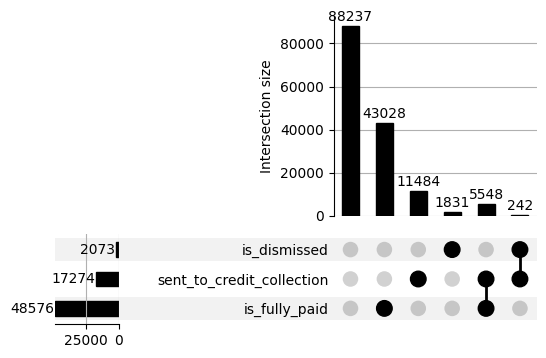

In [9]:
from upsetplot import UpSet, from_indicators

UpSet(from_indicators(['is_dismissed', 'is_fully_paid', 'sent_to_credit_collection'],
data=case_log),
show_counts=True).plot()

- *b)* 
    - Most cases (88,237) did not result in dismissal, full payment, or credit collection (all boolean features are False).
    - A large number of cases (43,028) have been fully paid, without being dismissed or sent to credit collection.
    - There are smaller groups of cases that were either dismissed, sent to credit collection, or paid, with varying combinations of these outcomes.

## Task 6


In [12]:
df = case_log.groupby('case:concept:name').agg(
    initial_fine_amount=('initial_fine_amount', 'max'),
    final_outstanding_payment=('final_outstanding_payment', 'max'))

fig3 = px.scatter(df, 
                 x='initial_fine_amount', 
                 y='final_outstanding_payment', 
                 title='Scatter Plot of Initial Fine Amount vs Final Outstanding Balance',
                 labels={'initial_fine_amount':'Initial Fine Amount', 
                         'final_outstanding_payment':'Final Outstanding Balance'},
                 width=700)

fig3.show()

- For initial fines in the lower range (below 1000), there seems to be a loose positive correlation between the initial fine amount and the final outstanding balance. As the fine increases, there is a tendency for the final balance to be positive, suggesting that larger fines are more likely to have an outstanding balance.

- There are a few outliers where the final outstanding balance is significantly high, even when the initial fine was not that large. For example, cases with an initial fine around 0 have a final outstanding balance exceeding 5,000. These might be cases where interest or penalties accumulated over time, or the case was sent to credit collection.

- A few points have negative final outstanding balances, indicating overpayment or cases where fines were reduced or dismissed.


## Task 7
- The employee with resource 29 handled 18% of all cases where the org:resource entry is not missing. This employee deducted a minimum of 2 points and a median of 5 points from offenders driving licences.

- 58/66 cases where 10 points (which is the highest amount in the log) where deducted from the offender, violated article number 142. After some research we found out that following article 142 10 points are deducted when exceeding speed limits by more than 60 km/h

# Session 3

## Task 1

- *a)* 
    - *Variant 1:* This process involves creating a fine, followed by a series of steps such as sending the fine, inserting a fine notification, adding a penalty, and finally sending the fine for credit collection.
    - *Variant 2:* This process is much shorter, involving creating a fine and then immediately payment within a short time.
    - *Variant 3:* This variant consists of creating a fine and then sending the fine with a significant delay.
    - *Variant 4:* This variant involves creating a fine, sending the fine with a delay, inserting a fine notification, adding a penalty and finally a payment by the offender.

    Unexpected behaviour:   
    - In variant 2 the fine is immediatly payed without it being sent, how is the offender informed about the violation?
    - In all the variants 1,3,4 the interval between fine creation and it being sent is mostly over 100 days, why does it take so long?

- *b)* 88.29%
- *c)* <img src="images/process_map.png" alt="Alt Text" style="width: 500px;"/>


## Task 2

- *a)* 
    - *Observation 1:* Out of the 79'860 fine notifications, only 3'891 are directly paid while 72'334 are added a penalty. This suggests that only about 4.9% of individuals pay their fines directly upon receiving a notification, while 90.6% of cases end up accruing penalties. This is an alarmingly low direct payment rate, raising concerns about the efficiency of the current system in prompting immediate compliance. Investigating the reasons for this low payment rate (e.g., communication issues, inability to pay, or lack of consequences for delays) could help improve the system and reduce the need for adding penalties and further administrative actions.

    - *Observation 2:* Most of the cases with added penalty are sent to credit collection and only a small part is paid directly. This suggests that the process of sending cases to credit collection is the primary mechanism used to resolve unpaid fines with added penalties, instead of direct payments. This heavy reliance on credit collection is likely a costly and resource-intensive process, involving legal and administrative fees, which could strain the system. It would be valuable to investigate whether measures can be taken to encourage earlier payments (e.g., reminders, incentives, flexible payment plans) before fines escalate to the collection stage. This could save resources and reduce the need for costly enforcement actions.

    - *Observation 3:* There is a surprisingly high number of cases (97,182) being sent to "Control Collection" after appeal actions. This suggests that many appeals are not being resolved in favor of the individual or that many cases are moving directly to enforcement, bypassing other steps. This might indicate inefficiencies in the appeal process, leading to excessive forwarding to collections or improper handling of appeals.

- *b)* Create Fine → Payment → Send Fine 
- *c)* This is quite difficult to answer but a possible explanation could be that the individual might have proactively paid the fine before the formal notification was sent. In some systems, people are aware of fines (for example, through online portals or informal communication), and they can pay them directly without waiting for the official fine letter.

## Task 3

<img src="images/repeated_activities.png" alt="Alt Text" style="width: 800px;"/>

- *a)* see the first column in the screenshot
- *b)* see the second column in the screenshot
- *c)* 
    - *2 occurences:* S92963


        Fine Issued and Notified: The fine was issued on June 27, 2004, for 68.25 units. It wasn’t sent to the person right away—it took until November 22, 2004 for the fine to be sent, and a formal notification was recorded on December 2, 2004.

        Penalty Added: On January 31, 2005, an additional penalty of 137.55 units was added to the case, increasing the total fine quite significantly. This penalty may have been added due to late action or non-payment by the due date.

        First Payment:The person made a first payment of 79.25 units on February 11, 2005, but this didn’t cover the full amount owed.

        Appeal to Judge: Instead of fully settling the case, the person decided to appeal to a judge on June 27, 2005. This likely indicates they weren’t happy with the fine or the added penalty and wanted to challenge it legally.

        Final Payment: On December 12, 2005, the person made a second and final payment of 148.55 units, likely closing out the case.
        
    - *5 occurences:*  V9576
    
        Fine Issuance and Notification: On July 31, 2002, the individual was fined an amount of 131.0 units for a traffic violation. A few months later, on October 25, 2002, the fine was officially sent to the individual, and by November 4, 2002, a notification regarding the fine was recorded in the system.

        Appeal Process: Rather than paying the fine immediately, the individual chose to appeal the fine. The appeal process began when the date of appeal to the prefecture was recorded on November 13, 2002, and the appeal was officially sent to the prefecture on December 2, 2002.

        Additional Penalty: On January 3, 2003, while the appeal was still under review, an additional penalty of 262.0 units was added to the original fine, which significantly increased the total amount owed.

        Appeal Result: The result of the appeal came back from the prefecture on February 28, 2003, and the individual was informed of the outcome on April 23, 2003. It seems that the appeal was unsuccessful because, soon after, on May 2, 2003, the individual escalated the matter further by appealing to a judge.
        
        Payments: Over the following year, the individual made six payments in multiple installments, starting on May 3, 2004 and ending on October 5, 2004. The payments gradually increased the amount settled, starting from 24.36 units and reaching a final total of 146.16 units by the end of the payment process.

## Task 4

The svg and bpmn files are in the files folder and can be downloaded by clicking the links below.


In [2]:
from IPython.display import display, HTML

# Create download links for BPMN and SVG files
html_content = """
<a href="files/RTFM-Template.bpmn" download>Download BPMN File</a><br>
<a href="files/diagram.svg" download>Download SVG File</a>
"""
display(HTML(html_content))


## Task 5

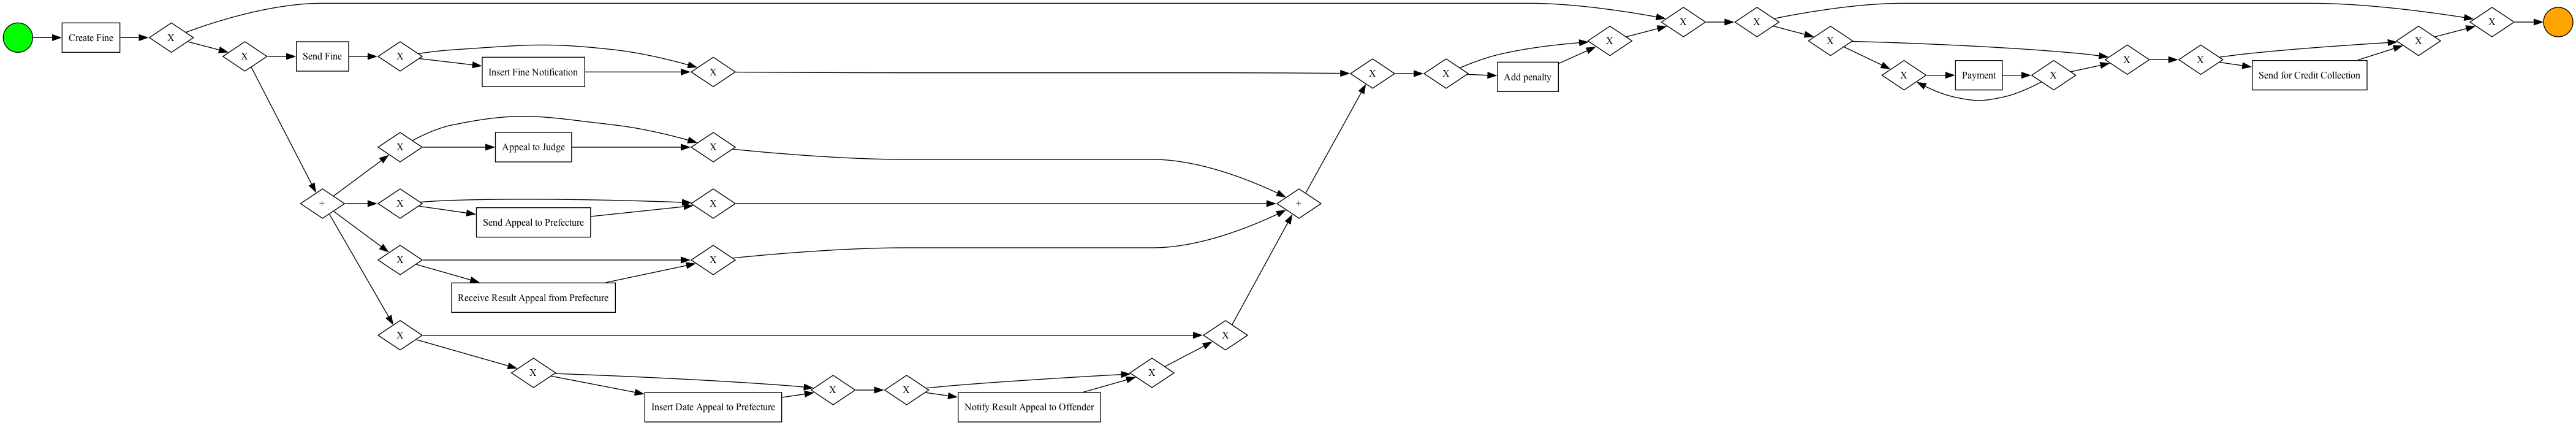

In [3]:
bpmn_model = pm4py.discover_bpmn_inductive(event_log, noise_threshold=0.1)
pm4py.view_bpmn(bpmn_model)

There are a number of traces that are not that common our handmade BPMN model covers the most usual traces only. Here are two traces of the generated model that are not present in our model from task 4.
 - We did not consider cases where the fine is not sent before being paid
 - We did not consider cases where the trace does not follow the strict sequence "Insert date appeal to prefecture -> Send Appeal to Prefecture -> Receive Result Appeal from Prefecture -> Notify Result Appeal to Offender". In the generated BPMN model, this actions can happen in any order.

# Session 5

## Task 1

- *a)* Condition to check: "Insert Fine Notification is always followed by Add penalty."

In [17]:
declare_model_a = {'response': {('Insert Fine Notification', 'Add penalty'): None}}
conf_result_a = pm4py.conformance_declare(event_log, declare_model_a, return_diagnostics_dataframe=True)
# Filter for cases that have at least one deviation (i.e., where the response constraint is violated)
non_conforming_cases_a = conf_result_a[conf_result_a['no_dev_total'] > 0]

negatives = conf_result_a[conf_result_a['dev_fitness'] < 1.0]
print('Rule A - Fitness:', conf_result_a['dev_fitness'].mean(), 'Violations:', len(negatives))
display(negatives[['case_id','dev_fitness']].head(5))

Rule A - Fitness: 1.0 Violations: 0


Empty DataFrame
Columns: [case_id, dev_fitness]
Index: []


- *b)* Condition to check: "Insert Date Appeal to Prefecture is always preceded by Send Fine."


In [15]:
declare_model_b = {'precedence': {('Send Fine', 'Insert Date Appeal to Prefecture'): None}}
conf_result_b = pm4py.conformance_declare(event_log, declare_model_b, return_diagnostics_dataframe=True)
violations_b = conf_result_b[conf_result_b['dev_fitness'] < 1.0]

# Display the results
print('Rule B - Fitness:', conf_result_b['dev_fitness'].mean(), 'Violations:', len(violations_b))
display(violations_b[['case_id', 'dev_fitness']].head(5))


Rule B - Fitness: 0.9998536942209217 Violations: 22


case_id  dev_fitness
21524   A5922          0.0
22246   A7016          0.0
23958  C11327          0.0
24346  C12875          0.0
24938  C14313          0.0

There are 22 cases violating this precedence constraint. one of them is A5922. This case has the following sequence of actions: 

Create Fine -> Insert Date Appeal to Prefecture -> Send Fine -> Insert Fine -> Notification -> Add penalty -> Send Appeal to Prefecture

Since "Insert Date Appeal to Prefecture" happens before "Send Fine", this case violates the rule. The sequence does not follow the expected order of events where the fine should have been sent before any appeal-related action was recorded.

- *c)* Condition to check: "Payment and Send for Credit Collection do not occur together in a case."


In [16]:
declare_model_c = {'not_coexistence': {('Payment', 'Send for Credit Collection'): None}}
conf_result_c = pm4py.conformance_declare(event_log, declare_model_c, return_diagnostics_dataframe=True)
violations_c = conf_result_c[conf_result_c['dev_fitness'] < 1.0]

# Display the results
print('Rule C - Fitness:', conf_result_c['dev_fitness'].mean(), 'Violations:', len(violations_c))
display(violations_c[['case_id', 'dev_fitness']].head(5))

Rule C - Fitness: 1.0 Violations: 0


Empty DataFrame
Columns: [case_id, dev_fitness]
Index: []

    
## Task 2
"Send Fine" is always preceded by "Create Fine"


In [28]:
declare_model = {'precedence': {('Create Fine', 'Send Fine'): None}}
conf_result = pm4py.conformance_declare(event_log, declare_model, return_diagnostics_dataframe=True)
violations = conf_result_b[conf_result_b['dev_fitness'] < 1.0]

# Display the results
print('Rule B - Fitness:', conf_result['dev_fitness'].mean(), 'Violations:', len(violations))
display(violations[['case_id', 'dev_fitness']].head(5))

Rule B - Fitness: 1.0 Violations: 22


case_id  dev_fitness
21524   A5922          0.0
22246   A7016          0.0
23958  C11327          0.0
24346  C12875          0.0
24938  C14313          0.0

It would make sense that a fine has to be created before it can be sent, but in 22 cases this doesn't apply. In most these cases this is because the fine is not sent directly after being created but "Insert date appeal to prefecture" happens in between.

## Task 3
First we need to convert the BPMN model from 3.5 to Petri Net

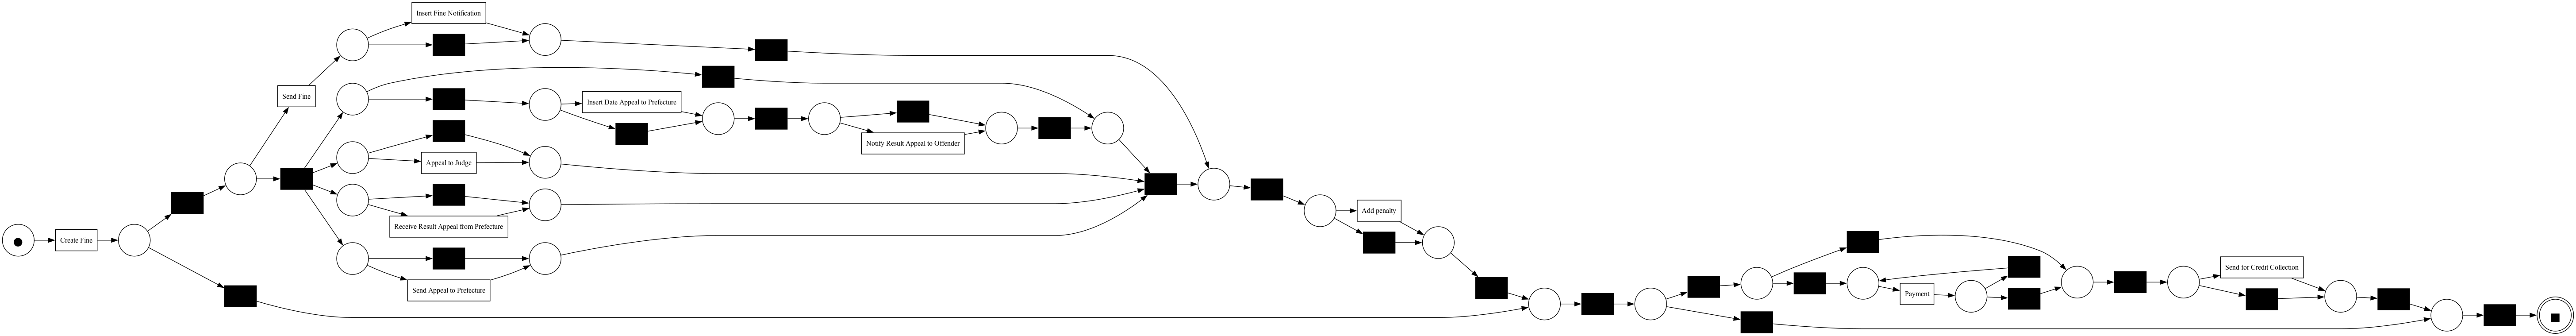

In [4]:
(pn, im, fm) = pm4py.objects.conversion.bpmn.variants.to_petri_net.apply(bpmn_model, parameters=None)
pm4py.view_petri_net(pn, im, fm)

Now we can calculate the fitness of the Event Log against the Petri Net using token-based replay.

In [5]:
display(pm4py.fitness_token_based_replay(event_log, pn, im, fm))
display(pm4py.fitness_alignments(event_log, pn, im, fm))

replaying log with TBR, completed traces :: 100%|██████████| 231/231 [00:00<00:00, 269.82it/s]


{'perc_fit_traces': 93.9628915342156,
 'average_trace_fitness': 0.994202661510755,
 'log_fitness': 0.9932889814273915,
 'percentage_of_fitting_traces': 93.9628915342156}

aligning log, completed variants :: 100%|██████████| 231/231 [00:02<00:00, 113.41it/s]


{'percFitTraces': 93.9628915342156,
 'averageFitness': 0.9870661806910803,
 'percentage_of_fitting_traces': 93.9628915342156,
 'average_trace_fitness': 0.9870661806910803,
 'log_fitness': 0.9799162447989826}

Next we check for deviations from the model by creating alignments and printing those with fitness less than 1.0. It helps identify which specific events in the log do not conform to the Petri net.

In [8]:
diagnostics = pm4py.conformance_diagnostics_alignments(event_log, pn, im, fm)
# Loop through diagnostic results to find non-conforming traces
for idx, item in enumerate(diagnostics):
    if item['fitness'] < 1.0:  # Non-conforming trace
        # Retrieve case ID from the event log using the index (idx)
        case_id = event_log['case:concept:name'].unique()[idx]  # Case ID based on the trace index
        
        print(f"\nNon-conforming Trace Found (Case ID: {case_id}) with Fitness: {item['fitness']}")
        print("Alignment:")
        for (log_move, model_move) in item['alignment']:
            print(f"Log move: {log_move} ; Model move: {model_move}")

        # Extract the corresponding trace from the event log for inspection
        non_conforming_trace = event_log[event_log['case:concept:name'] == case_id]
        print(f"Non-conforming Trace Events (Case ID: {case_id}):")
        print(non_conforming_trace[['case:concept:name', 'concept:name', 'time:timestamp']])
        
        # Optionally break after the first violating trace, or keep looping for more
        break

aligning log, completed variants :: 100%|██████████| 231/231 [00:01<00:00, 116.41it/s]



Non-conforming Trace Found (Case ID: A10001) with Fitness: 0.7142857142857143
Alignment:
Log move: Create Fine ; Model move: Create Fine
Log move: >> ; Model move: None
Log move: Send Fine ; Model move: Send Fine
Log move: Insert Fine Notification ; Model move: Insert Fine Notification
Log move: Insert Date Appeal to Prefecture ; Model move: >>
Log move: >> ; Model move: None
Log move: >> ; Model move: None
Log move: Add penalty ; Model move: Add penalty
Log move: Send Appeal to Prefecture ; Model move: >>
Log move: >> ; Model move: None
Log move: >> ; Model move: None
Log move: >> ; Model move: None
Log move: >> ; Model move: None
Non-conforming Trace Events (Case ID: A10001):
   case:concept:name                      concept:name  \
12            A10001                       Create Fine   
13            A10001                         Send Fine   
14            A10001          Insert Fine Notification   
15            A10001  Insert Date Appeal to Prefecture   
16            A10001  

### a) Case ID: A10001 Process Steps

For **Case ID: A10001**, the process followed these steps:

1. **Create Fine** (2007-03-19)
2. **Send Fine** (2007-07-17)
3. **Insert Fine Notification** (2007-07-25)
4. **Insert Date Appeal to Prefecture** (2007-08-02)
5. **Add Penalty** (2007-09-23)
6. **Send Appeal to Prefecture** (2007-09-24)

#### Deviations:
When comparing this trace to the BPMN model, we found several deviations:

- There are points where the process did something unexpected, represented by `>>` in the log. For example, the model didn't anticipate the event **"Insert Date Appeal to Prefecture"** at that point.
  
- The most significant issue is that the **appeal was sent after the penalty** had already been added. This doesn't seem correct, as typically, the appeal should be sent **before** the penalty is applied.


### b) Is the variant expected or unexpected?

This behavior is **unexpected**. Typically, an appeal should be raised **before** a penalty is applied. The fact that the penalty was added first, and then the appeal was sent, suggests that something went wrong.

#### ii. If the variant is unexpected, explain the behavior:

Looking more closely at the case:

- The **penalty** was added on **2007-09-23**, which is almost **two months** after the appeal was **inserted** on **2007-08-02**.
- However, the **appeal wasn’t sent** until **2007-09-24**, which was **after** the penalty had already been applied.

This sequence doesn't make sense, as appeals should usually prevent penalties if they are handled correctly and in time.

---

### Interpretation of the unexpected behavior:

The most likely explanation is a **delay in processing the appeal**. Either the appeal wasn’t processed on time, or there was a mix-up, causing the penalty to be added **before** the appeal was properly sent. This may point to issues in how the process manages appeals, leading to **delays or errors** that result in penalties being applied prematurely.


## Task 4


### a) Steps to Check Log Conformance for:
#### " If the outstanding balance after the event is 0 or less, then there is no further event.":

1. **Iterate through the log** and group by `case:concept:name`.
2. For each case, track the `outstanding_balance` after every event.
3. Once the balance reaches **0 or less**, check if any additional events are logged.
4. **Report violations** (cases where further events occurred after the balance was zero or negative).


In [28]:
def check_outstanding_balance_conformance(event_log):
    # Dictionary to store violating cases
    violating_cases = []
    
    # Grouping events by case ID
    grouped_cases = event_log.groupby('case:concept:name')

    # Iterate over each case
    for case_id, events in grouped_cases:
        events = events.sort_values(by='time:timestamp')  # Sorting events by time
        balance_breached = False  # Flag to check if balance breached before
        
        # Check each event in the case
        for idx, event in events.iterrows():
            outstanding_balance = event['outstanding_balance']
            
            # If balance <= 0 and there are more events, record violation
            if outstanding_balance <= 0:
                balance_breached = True
            elif balance_breached:
                # If more events occurred after balance became 0 or less, report violation
                violating_cases.append(case_id)
                break  # No need to check further events in this case
    
    return violating_cases

# Check conformance
violating_cases = check_outstanding_balance_conformance(event_log)

# Display the first 5 violating case IDs
print("First 5 violating cases:", violating_cases[:5])

# Display the total number of violating cases
print("Total violating cases:", len(violating_cases))

# Display the Fuzzy Truth Value
print("Fuzzy Truth Value:", (len(event_log)-len(violating_cases))/len(event_log))

First 5 violating cases: ['A10125', 'A1097', 'A11192', 'A1161', 'A11750']
Total violating cases: 1727
Fuzzy Truth Value: 0.9969241455465119


### Violation Summary:

- **1727 cases** violate the statement: 
  - "If the outstanding balance after the event is 0 or less, then there is no further event."
  
- **Fuzzy Truth Value**: 0.9969241455465119

#### Example of One Violating Case:
- **Case ID**: A10125

#### Explanation:
- The offender pays 49 for the fine amount and expenses. The outstanding balance is temporarely 0. Then a further event happens, a penalty of 79 is added. This violates the statement.

### b) Steps to Check Log Conformance for: 
#### "An appeal to the prefecture must be raised 60 days after Insert Fine Notification or earlier":

1. **Identify** the `Insert Fine Notification` event for each case.
2. **Identify** the event related to raising the appeal (`Insert Date Appeal to Prefecture`).
3. **Calculate** the time difference between `Insert Fine Notification` and the appeal event.
4. **Check** if the appeal was raised within **60 days** after the fine notification.
5. **Report violations** where the appeal was raised after the **60-day limit**.


In [17]:
def check_appeal_timing(event_log):
    # Dictionary to store violating cases
    violating_cases = []

    # Group events by case ID
    grouped_cases = event_log.groupby('case:concept:name')

    # Iterate over each case
    for case_id, events in grouped_cases:
        events = events.sort_values(by='time:timestamp')  # Sorting events by time
        notification_time = None
        appeal_time = None

        # Iterate over each event in the case
        for idx, event in events.iterrows():
            event_name = event['concept:name']
            event_time = event['time:timestamp']

            # Look for 'Insert Fine Notification'
            if event_name == 'Insert Fine Notification':
                notification_time = event_time
            
            # Look for appeal-related events (replace 'Insert Date Appeal to Prefecture ' with the actual event name)
            if event_name == 'Insert Date Appeal to Prefecture':
                appeal_time = event_time

        # If both notification and appeal were found, check the time difference
        if notification_time and appeal_time:
            time_difference = (appeal_time - notification_time).days

            # If appeal was raised after 60 days, mark as violation
            if time_difference > 60:
                violating_cases.append({
                    'case_id': case_id,
                    'notification_time': notification_time,
                    'appeal_time': appeal_time,
                    'days_after_notification': time_difference
                })
    
    return violating_cases

# Run the conformance check for appeal timing
violations = check_appeal_timing(event_log)

# Display the first 5 violating cases
print("First 5 violating cases:")
for violation in violations[:5]:
    print(f"Case ID: {violation['case_id']}, Days After Notification: {violation['days_after_notification']}")

# Display the total number of violating cases
print("Total violating cases:", len(violations))

# Display the Fuzzy Truth Value
print("Fuzzy Truth Value:", (len(event_log)-len(violations))/len(event_log))

First 5 violating cases:
Case ID: A10102, Days After Notification: 65
Case ID: A10249, Days After Notification: 100
Case ID: A10338, Days After Notification: 72
Case ID: A10495, Days After Notification: 70
Case ID: A10625, Days After Notification: 62
Total violating cases: 582
Fuzzy Truth Value: 0.9989634352681355


### Violation Summary:

- **582 cases** violate the statement: 
  - "An appeal to the prefecture must be raised 60 days after Insert Fine Notification or earlier."
  
- **Fuzzy Truth Value**: 0.9989634352681355

#### Example of One Violating Case:
- **Case ID**: A10102
  - **Insert Fine Notification**: 2007-07-07 00:00:00+00:00
  - **Insert Date Appeal to Prefecture**: 2007-09-10 00:00:00+00:00
  - **Time Difference**: 65 days (which is **5 days more** than allowed).

#### Explanation:
- The offender likely appealed against the fine as a reaction to an **added penalty** on **2007-09-05 00:00:00+00:00**, just **5 days before** the appeal was made.


# Analytics Lists

## Interesting Findings
- The median of the initial fine amount is very distant from the maximum, in fact only 9 entries have an initial fine amount of over 900. 


## Process Improvements 
- All the missing values in the amount and payment columns turned out to be a hurdle for addition and other multiplications so we replaced them with 0.

## Open Questions
- Why are so many cases closed even if the final outstanding payment is not equal to 0?